In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# import tensorflow as tf
# from tensorflow.keras import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Dense
from sklearn import preprocessing

from sklearn.model_selection import *
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
import seaborn as sns
from scipy import stats

from models import *

## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR'])


In [3]:
y = np.zeros(124)

x = np.zeros((124, 2*98))
for i, cell in enumerate(data.keys()):
    x[i, :98] = data[cell]["DeltaQ_logVars"][0:]
    #x[i, 97:2*97] = np.log10(-data[cell]["DeltaQ_mins"][1:])
    #x[i, 97:2*97] = data[cell]["DeltaQ_means"][1:]
    #x[i, 97:2*97] = data[cell]["DeltaT_logVars"][1:]
    x[i, 98:2*98] = data[cell]["DeltaT_max"][0:]
    #x[i, :98] = data[cell]["DeltaIR"][0:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [4]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])



Stage 1:

Epoch 200/2000, loss: 4170.74
Epoch 400/2000, loss: 2750.89
Epoch 600/2000, loss: 1877.04
Epoch 800/2000, loss: 1156.67
Epoch 1000/2000, loss: 616.36
Epoch 1200/2000, loss: 327.76
Epoch 1400/2000, loss: 236.62
Epoch 1600/2000, loss: 190.93
Epoch 1800/2000, loss: 920.09
Epoch 2000/2000, loss: 63.88
train 	 5.2297716
test 	 115.214005
sec 	 325.4944


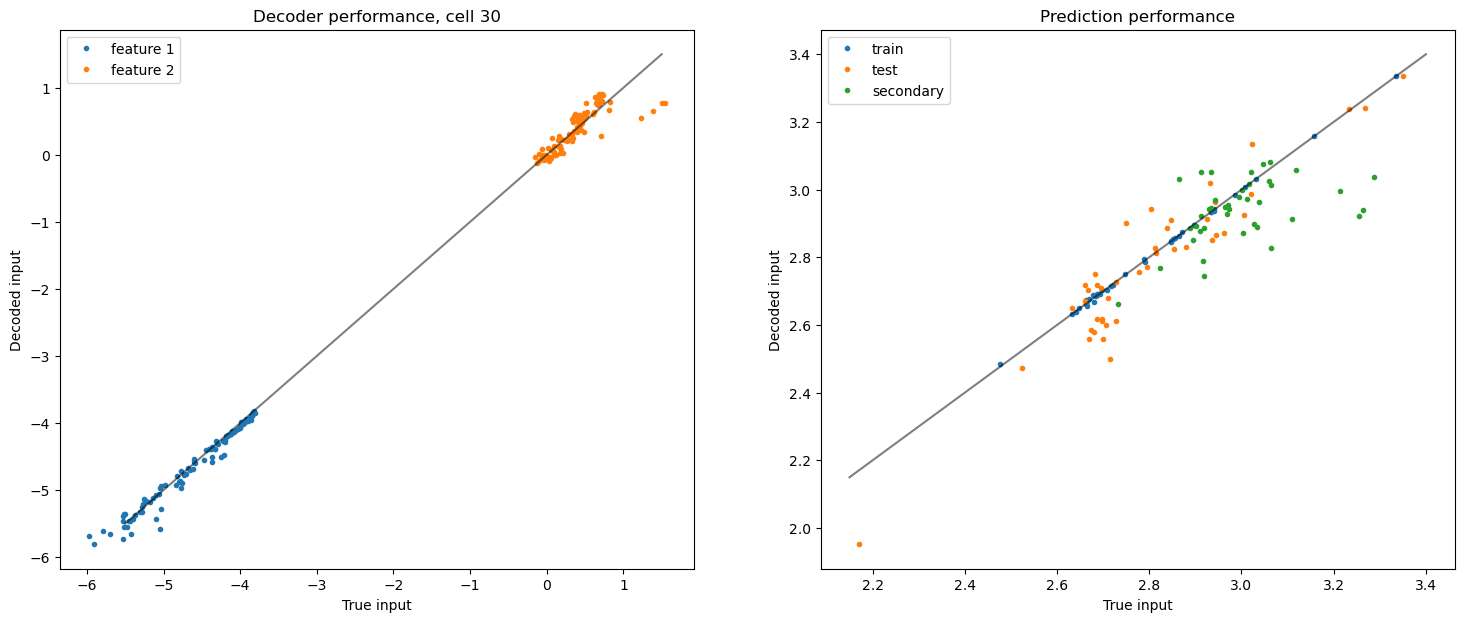


Stage 2:

Epoch 100/1000, loss: 1.04
Epoch 200/1000, loss: 0.97
Epoch 300/1000, loss: 0.90
Epoch 400/1000, loss: 0.86
Epoch 500/1000, loss: 0.82
Epoch 600/1000, loss: 0.78
Epoch 700/1000, loss: 0.74
Epoch 800/1000, loss: 0.71
Epoch 900/1000, loss: 0.67
Epoch 1000/1000, loss: 0.64
train 	 10.120501
test 	 103.61548
sec 	 311.49316


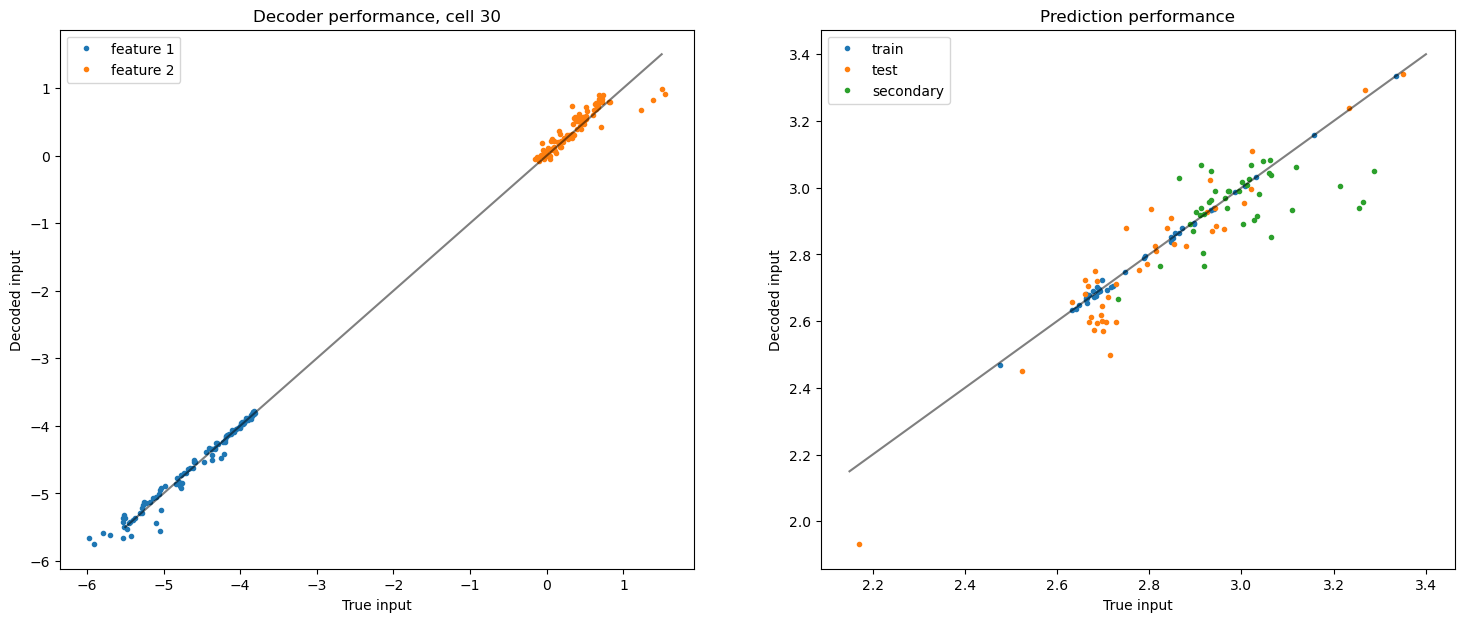

In [40]:
train_policy = {
    "num_stages": 2,
    "epochs": [2000, 1000],
    "learning_rates": [7e-4, 5e-4],
    "batch_sizes": [64, 64],
    "prediction_weights": [1, 0.0001],
    "decoding_weights": [10, 1],
    "en_weights": [1, 1]
}


model = AutoEncoder_ElasticNet(n_features=2, n_cycles=98)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [41]:
model.encoder(x[5])

tensor([0.0000, 2.3474, 0.0000, 0.3258, 2.2432, 2.8434, 3.4443, 2.9550, 0.5296,
        0.0000, 0.3925, 2.6556, 0.0000, 2.3383, 0.0000, 1.2821, 0.0000, 1.9861,
        2.6206, 0.0000, 0.0000, 0.0000, 3.6669, 0.0000, 0.0000, 2.9575, 3.8084,
        1.2132, 0.0000, 0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>)

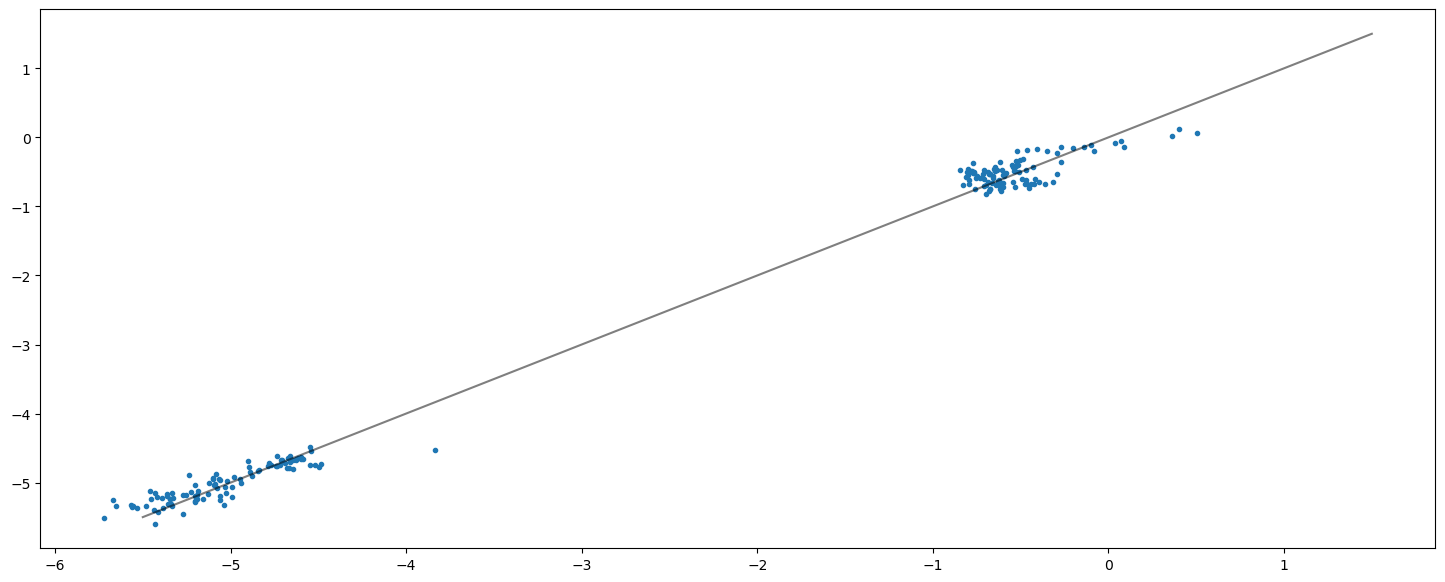

In [42]:
plt.plot(x[3].detach().numpy(), model.forward(x[3]).detach().numpy(), ".")
plt.plot(np.linspace(-5.5, 1.5, 3), np.linspace(-5.5, 1.5, 3), "k", alpha = 0.5)

In [43]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.3344], grad_fn=<AddBackward0>)


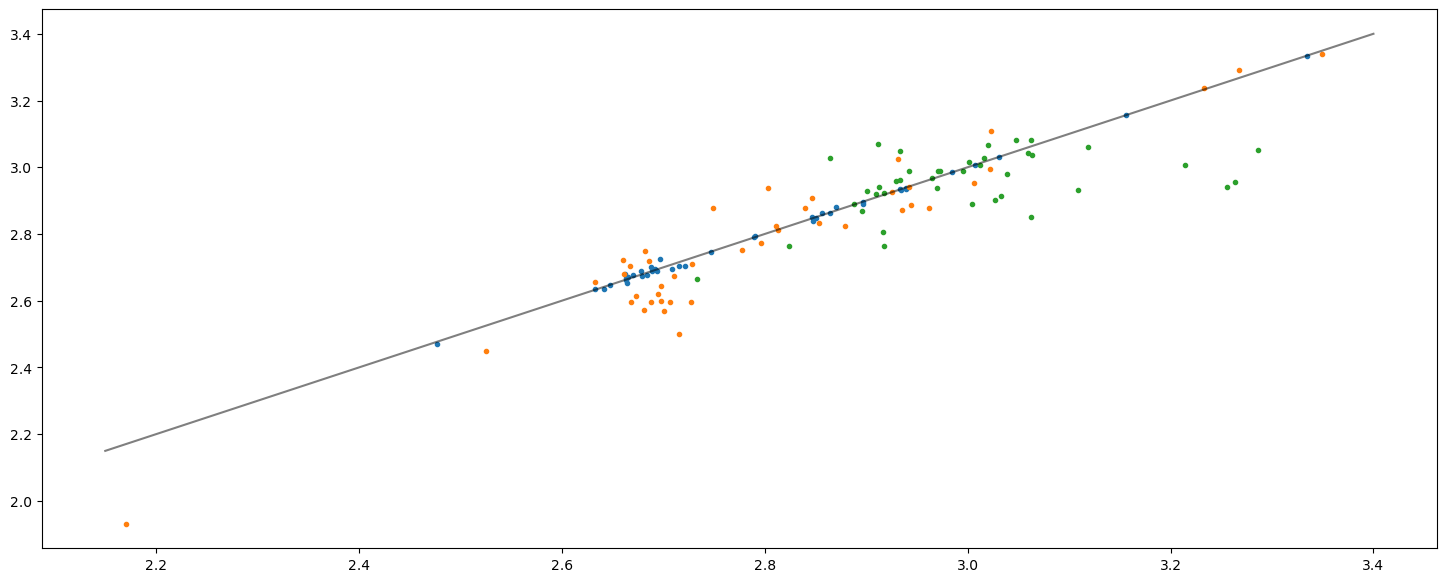

In [44]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

# SVR

In [45]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t[0])

[0.         2.7789023  0.00947915 0.         2.5482674  3.0005302
 3.9141812  3.1487293  0.6092644  0.         0.         2.7842333
 0.         2.6168551  0.         1.4562782  0.         2.2994936
 2.9633267  0.         0.         0.         4.0115137  0.
 0.         3.2317371  4.1754527  1.2469357  0.         0.
 0.         0.        ]


In [46]:
scaler = preprocessing.StandardScaler().fit(list(x_t))
x_t = scaler.transform(list(x_t))
x_te = scaler.transform(list(x_te))
x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [47]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, vdim=1, num_heads=1):
        super(AttentionModel, self).__init__()

        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.d_model = d_model

    def reshape_input(self,X):
        return X.reshape(X.shape[0], -1)

    def scaled_dot_product_attention(self, Q, K, V):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
    
    def forward(self, X):
        X = self.reshape_input(X)
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        attn_output = self.scaled_dot_product_attention(Q, K, V)
        return attn_output

In [48]:
# parameters
lr = 0.001
feat_dim = 2*16
d_model = 12
nepoch = 2000
batch_size = 1

In [49]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: 50 | rmse:  652.204 | rmse_test:  656.897 | rmse_stest:  1060.055
Epochs: 100 | rmse:  618.151 | rmse_test:  676.171 | rmse_stest:  1049.424
Epochs: 150 | rmse:  615.555 | rmse_test:  689.666 | rmse_stest:  1050.039
Epochs: 200 | rmse:  609.800 | rmse_test:  661.805 | rmse_stest:  1049.458
Epochs: 250 | rmse:  612.404 | rmse_test:  695.417 | rmse_stest:  1049.842
Epochs: 300 | rmse:  606.724 | rmse_test:  679.020 | rmse_stest:  1050.538
Epochs: 350 | rmse:  604.282 | rmse_test:  676.403 | rmse_stest:  1052.523
Epochs: 400 | rmse:  612.992 | rmse_test:  736.031 | rmse_stest:  1062.239
Epochs: 450 | rmse:  598.671 | rmse_test:  679.462 | rmse_stest:  1062.811
Epochs: 500 | rmse:  590.596 | rmse_test:  839.003 | rmse_stest:  1102.884
Epochs: 550 | rmse:  602.444 | rmse_test:  1043.519 | rmse_stest:  1144.884
Epochs: 600 | rmse:  583.905 | rmse_test:  1049.644 | rmse_stest:  1120.878
Epochs: 650 | rmse:  607.325 | rmse_test:  1055.255 | rmse_stest:  1094.411
Epochs: 700 | rmse:  56

In [1189]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

59.93321176018286
119.23445634331097
326.7872557062419


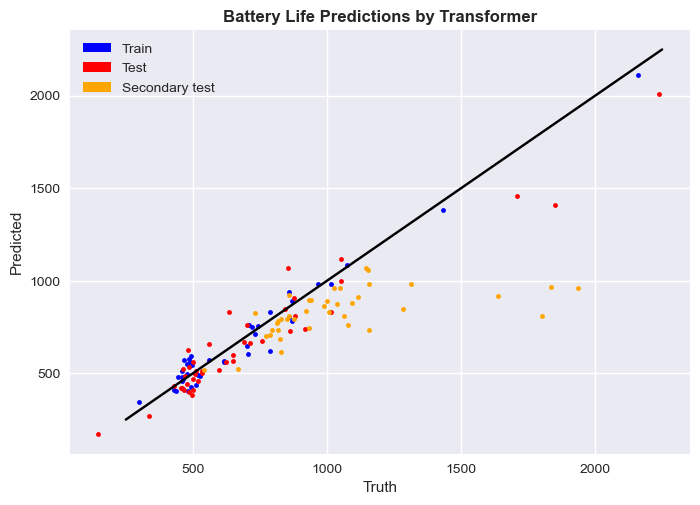

In [1190]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)